In [1]:
import os

import numpy as np

import cv2 as cv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image

from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR

from torchinfo import summary
from tqdm import tqdm

### Second Variation

This time we will augment the data and see if there are changes in the accuracies.
Let's experiment with a few basic augmentation methods, such as the following:
- Use [color jitter](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html) to augment the train data.
- Randomly flip the train data.
- Randomly flip the train samples.

The new workflow :


<img src="img/augmentation.JPG" style="display:block; margin:auto">

The green block have already been implemented. In this variation, the focus is on the blue block (Think Augmentation). This will help us gauge the impact of the augmentation technique.  
In this variation we will skip Data ingestion and Data Check since it has already been done and start from the Data Loader.

In [2]:
data_path = 'img\chest_xray'

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

The augmentation processes are incorporated in the compose functions themselves and thus we don’t need to change the data loader portion of the code. We will reuse the exact code proccess from the compose functions and run it on the iterations.

In [5]:
train_data = datasets.ImageFolder(
    os.path.join(data_path, 'train'), transform=train_transform
    )
test_data = datasets.ImageFolder(
    os.path.join(data_path, 'test'), transform=test_transform
    )

In [6]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)
class_names =  train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


In [7]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        #INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(
            in_channels=3, out_channels=8, kernel_size=(3,3),padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(4)
        )
        self.pool11 = nn.MaxPool2d(2,2)

        # CONVOLUTION BLOCK
        self.convblock2 = nn.Sequential(
            nn.Conv2d(
            in_channels=8, out_channels=16, kernel_size=(3,3),padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
        )
        self.pool22 = nn.MaxPool2d(2,2)

        # TRANSITION BLOCK
        self.convblock3 = nn.Sequential(
            nn.Conv2d(
            in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU()
            #nn.BatchNorm2d(10),
        )
        self.pool33 = nn.MaxPool2d(2,2)

        # CONVOLUTION BLOCK
        self.convblock4 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=32, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(
            in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=32, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(
            in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(14),
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(
            in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
            nn.Conv2d(
            in_channels=16, out_channels=2, kernel_size=(4,4), padding=0, bias=False),
        )

    def forward(self,x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)

        x = x.view(-1,2)
        return F.log_softmax(x, dim=-1)

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(f'Avaliable processor: {device}')
model = Net().to(device)
summary(model, input_size=(3,224,224), col_names=('output_size', 'num_params'))

Avaliable processor: cuda


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 2]                    --
├─Sequential: 1-1                        [8, 222, 222]             --
│    └─Conv2d: 2-1                       [8, 222, 222]             216
│    └─ReLU: 2-2                         [8, 222, 222]             --
├─MaxPool2d: 1-2                         [8, 111, 111]             --
├─Sequential: 1-3                        [16, 109, 109]            --
│    └─Conv2d: 2-3                       [16, 109, 109]            1,152
│    └─ReLU: 2-4                         [16, 109, 109]            --
├─MaxPool2d: 1-4                         [16, 54, 54]              --
├─Sequential: 1-5                        [10, 54, 54]              --
│    └─Conv2d: 2-5                       [10, 54, 54]              160
│    └─ReLU: 2-6                         [10, 54, 54]              --
├─MaxPool2d: 1-6                         [10, 27, 27]              --
├─Sequenti

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    proccessed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # Get data.
        data, target = data.to(device), target.to(device)

        # Initialization of gradient.
        optimizer.zero_grad()

        # Prediction on data.
        y_pred = model(data)

        # Calculate the loss, given the prediction. (Cost function).
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation.
        loss.backward()
        optimizer.step()

        # Track the training loss and accuracy.
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        proccessed += len(data)

        pbar.set_description(
            desc=f'Loss={loss.item()} '
                 f'Batch_id={batch_idx} '
                 f'Accuracy={100*correct/proccessed:.2f}'
    )

        train_acc.append(100*correct/proccessed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
    f'\nTest set: '
    f'Average loss: {test_loss:.4f}, '
    f'Accuracy: {correct}/{len(test_loader.dataset)} '
    f'({100. * correct / len(test_loader.dataset):.2f}%)\n'
)
    test_acc.append(100.*correct/len(test_loader.dataset))

In [11]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()['param_groups'][0]['lr'])
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/327 [00:00<?, ?it/s]

Loss=0.693146288394928 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:42<00:00,  2.01it/s] 


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 1


Loss=0.6931418776512146 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:37<00:00,  2.08it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 2


Loss=0.6931425929069519 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:36<00:00,  2.09it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 3


Loss=0.6931462287902832 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:38<00:00,  2.07it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 4


Loss=0.6931478977203369 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:38<00:00,  2.06it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 5


Loss=0.6931465268135071 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:38<00:00,  2.07it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 6


Loss=0.693132758140564 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:40<00:00,  2.04it/s] 


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 7


Loss=0.6931353807449341 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:41<00:00,  2.03it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 8


Loss=0.6931309103965759 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:38<00:00,  2.06it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 9


Loss=0.6931465864181519 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:40<00:00,  2.03it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 10


Loss=0.6931267976760864 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:41<00:00,  2.03it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 11


Loss=0.6931241750717163 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:39<00:00,  2.05it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 12


Loss=0.6931231617927551 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [03:02<00:00,  1.79it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 13


Loss=0.6931052803993225 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:51<00:00,  1.91it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 14


Loss=0.6930964589118958 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:40<00:00,  2.04it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)



Text(0.5, 1.0, 'Test Accuracy')

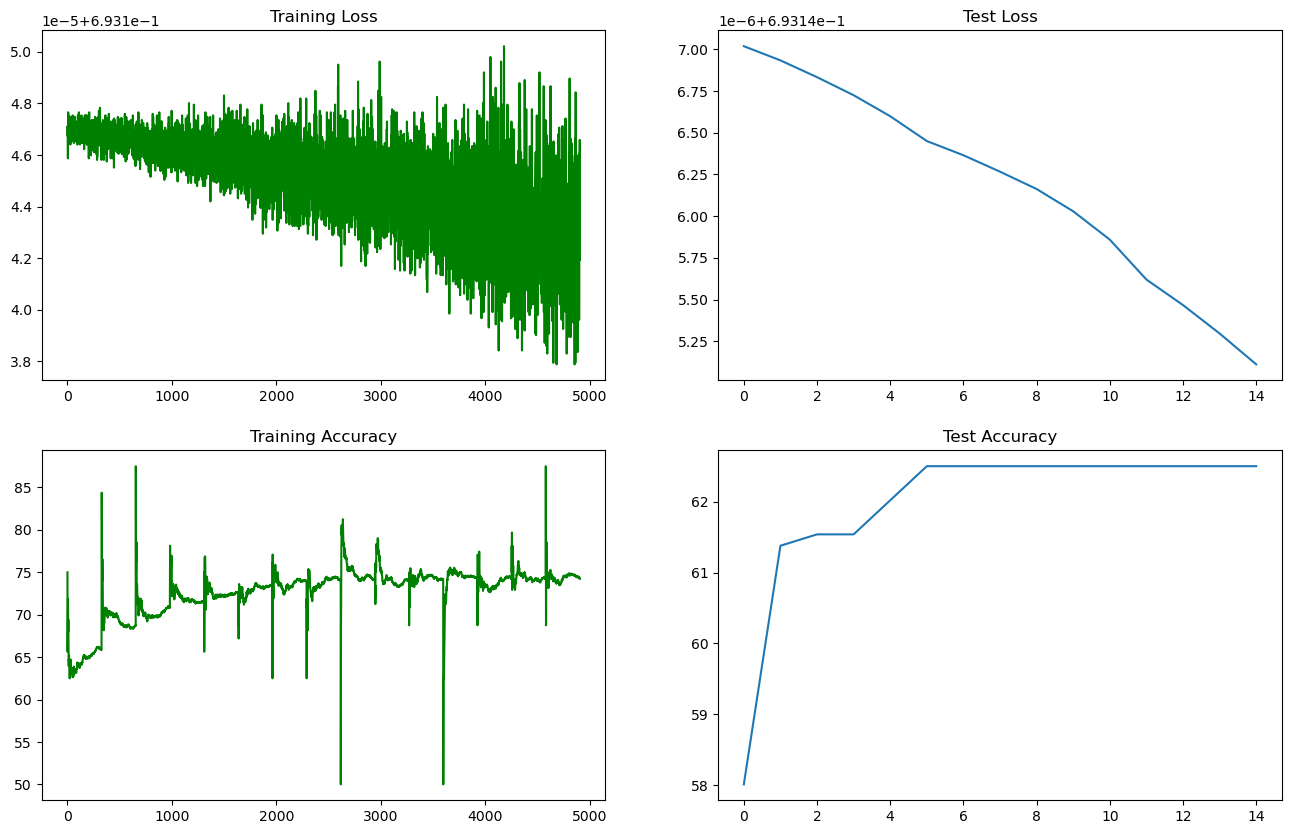

In [15]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

fig, axs = plt.subplots(2, 2, figsize = (16,10))

axs[0,0].plot(train_losses1, color='green')
axs[0,0].set_title('Training Loss')

axs[1,0].plot(train_acc1, color='green')
axs[1,0].set_title('Training Accuracy')

axs[0,1].plot(test_losses1)
axs[0,1].set_title('Test Loss')

axs[1,1].plot(test_acc1)
axs[1,1].set_title('Test Accuracy')